In [ ]:
from datasets import get_datasets
from experiments import get_experiments
from file_loader import get_results

from metrics import mean, adjusted_imbalance_ratio, number_of_discriminative_features

from collections import defaultdict, Counter
from tabulate import tabulate

In [ ]:
EXPERIMENTS = [
    # "SVMSMOTE-default=SVMSMOTE-META=25-metric=[harmonic_mean_recall_2]",
    # "weighting-default=weighting-META=25-metric=[harmonic_mean_recall_2]",
    # "none-default=none-META=25-metric=[harmonic_mean_recall_2]",

    # "RF",
    # "SVMSMOTE+RF",
    # "weighting+RF",

    # "SVMSMOTE-default=SVMSMOTE-META=25-callback",
    # "weighting-default=weighting-META=25-callback",
    # "none-default=none-META=25-callback",

    # "SVMSMOTE-default=SVMSMOTE-META=25-sampling_strategy=False",
    "SVMSMOTE-default=SVMSMOTE-META=25",
    "weighting-default=weighting-META=25",
    "none-default=none-META=25",

    # "all_SMOTE_like+weighting+none-default=SVMSMOTE-META=25",
    # "weighting+none-default=weighting-META=25",
    # "BorderlineSMOTE+weighting+none-default=BorderlineSMOTE-META=25",
    # "SMOTETomek+weighting+none-default=weighting-META=25",
    # "SMOTEENN+weighting+none-default=weighting-META=25",
    # "ADASYN+weighting+none-default=weighting-META=25",
    # "SMOTE+weighting+none-default=weighting-META=25",
    # "SVMSMOTE+weighting+none-default=SVMSMOTE-META=25",
]
assert set(EXPERIMENTS) <= set(get_experiments().keys()), set(EXPERIMENTS) - set(get_experiments().keys())

In [ ]:
DATASETS = get_datasets()
RESULTS = get_results(DATASETS, EXPERIMENTS)

In [ ]:
def format_scores_for_dataset(RESULTS, EXPERIMENTS, dataset_name, ratio):
    res = []
    for experiment_name in EXPERIMENTS:
        score = mean(RESULTS[dataset_name][ratio][experiment_name].values())
        res.append(f"{100 * score:.2f}")
    return res


def make_table(DATASETS, RESULTS, EXPERIMENTS, adjusted=True, additional_info=True, scores_=True):
    header = ["name", "imbalance_ratio"]
    if scores_:
        header += EXPERIMENTS 
    if adjusted:
        header += ["adjusted_imbalance_ratio", "adjusted_imbalance_ratio_assuming_100%_discriminative_features", "number_of_discriminative_features"]
    if additional_info:
        header += ["original_imbalace_ratio"]
        header += ["#feaures", "#instances"]
        header += ["#minority", "#majority"]

    table = []
    for dataset_name, X, y, ratio in DATASETS:
        row = [dataset_name, f"{1/ratio:.2f}"]
        if scores_:
            row += format_scores_for_dataset(RESULTS, EXPERIMENTS, dataset_name, ratio) 
        if adjusted:
            p_star = number_of_discriminative_features(X, y)
            row += [f"{adjusted_imbalance_ratio(X, y, p_star=p_star):.2f}", f"{adjusted_imbalance_ratio(X, y, p_star=len(y)):.2f}", p_star]
        if additional_info:
            original_ratio = max(r for n, _, _, r in DATASETS if n == dataset_name)
            row += [f"{1/original_ratio:.2f}"]
            row += [X.shape[1], len(y)]
            row += [min(Counter(y).values()), max(Counter(y).values())]
        table.append(row)
    return table, header


def print_table_pdf(table, header, size):
    assert len(header) == len(size), f"header: {len(header)}, size: {len(size)}"
    print("\\begin{tabular}{|p{" + str(size[0]) + "cm}||", end="")
    # print("p{2.5cm}|p{2.0cm}|p{3.0cm}|p{2.0cm}", end="")
    print("|".join(f"p{{{s}cm}}" for s in size[1:]), end="")
    print("|}")
    print("\\hline")
    print("&".join(header).replace("_", "\\_").replace("#", "\\#") + "\\\\")
    print("\\hline")
    for line in table:
        print("&".join(str(e) for e in line) + "\\\\")
    print("\\hline")
    print("\\end{tabular}")


def print_table_excel(table, header):
    cpy = table.copy()
    cpy.insert(0, header)
    for line in cpy:
        print(";".join(str(v) for v in line).replace(".", ","))

In [ ]:
def extract_metric_from_results(RESULTS, metric):
    res = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {})))
    for dataset_name in RESULTS:
        for ratio in RESULTS[dataset_name]:
            for experiment_name in RESULTS[dataset_name][ratio]:
                for fold, dct in RESULTS[dataset_name][ratio][experiment_name].items():
                    res[dataset_name][ratio][experiment_name][fold] = dct[metric]
    return res

In [ ]:
METRICS = [
    # f"minority_recall_default",
    # f"minority_precision_default",
    # f"minority_f1_default",
    # f"minority_f2_default",
    # f"weighted_harmonic_mean_recall_2_default",

    # f"minority_recall_tpr-1*fpr",
    # f"minority_precision_tpr-1*fpr",
    # f"minority_f1_tpr-1*fpr",
    # f"minority_f2_tpr-1*fpr",
    # f"weighted_harmonic_mean_recall_2_tpr-1*fpr",

    # f"minority_recall_weighted_harmonic_mean",
    # f"minority_precision_weighted_harmonic_mean",
    # f"minority_f1_weighted_harmonic_mean",
    # f"minority_f2_weighted_harmonic_mean",
    # f"weighted_harmonic_mean_recall_2_weighted_harmonic_mean",

    "auc_roc",
    # "pr_auc_roc",
]

header2 = ["name"] + EXPERIMENTS
table2 = []
for metric in METRICS:
    table1, header1 = make_table(DATASETS, extract_metric_from_results(RESULTS, metric), EXPERIMENTS, adjusted=0, additional_info=0, scores_=1)

    print(metric)
    print()
    print()

    print(tabulate(table1, headers=header1))
    print()
    print()

    print_table_excel(table1, header1)
    print()
    print()

In [ ]:
all = [88.65, 87.0, 87.78, 85.32, 96.39, 78.82, 76.07, 72.53, 77.68, 73.51, 76.07, 77.51, 94.05, 92.72, 87.37, 87.86, 86.48, 84.55, 94.65, 81.03, 83.78, 83.99, 94.96, 91.93, 90.23, 92.89, 89.59, 85.55, 89.27, 97.09, 89.41, 96.38, 89.91, 84.96, 86.95, 87.56, 81.76, 76.79, 76.76, 79.68, 79.31]
svm = [88.59, 86.88, 87.23, 85.15, 96.33, 76.78, 76.49, 64.97, 77.49, 73.62, 76.01, 77.27, 94.05, 92.42, 87.82, 87.87, 87.2, 84.44, 94.37, 81.31, 83.46, 83.05, 94.74, 92.01, 88.25, 92.56, 90.1, 84.69, 89.15, 96.75, 89.45, 96.79, 90.57, 85.02, 86.4, 88.04, 84.92, 76.95, 74.92, 80.66, 79.37]
borderline = [88.85, 87.25, 87.97, 85.57, 96.41, 85.6, 75.17, 73.39, 77.42, 73.4, 76.18, 77.58, 93.71, 92.4, 87.68, 87.62, 86.69, 84.46, 94.65, 80.94, 83.31, 84.49, 94.73, 92.75, 88.28, 92.14, 88.32, 84.73, 88.38, 97.96, 89.19, 97.54, 88.16, 84.82, 85.81, 86.6, 83.28, 76.76, 74.29, 80.33, 79.5]
adasyn = [88.73, 87.41, 87.41, 85.32, 96.36, 78.86, 81.09, 73.09, 77.33, 73.39, 75.98, 77.51, 93.78, 91.67, 87.4, 87.64, 87.58, 84.69, 94.48, 81.62, 83.23, 83.52, 94.65, 91.22, 89.19, 92.05, 88.15, 85.97, 89.31, 97.32, 89.97, 97.46, 89.91, 84.84, 86.15, 87.7, 82.92, 76.38, 75.03, 78.82, 79.37]
askl = [88.45, 87.39, 87.98, 85.36, 96.18, 89.73, 80.55, 65.22, 77.47, 73.43, 75.82, 77.69, 93.52, 91.88, 87.73, 88.09, 87.08, 84.42, 94.26, 81.41, 82.92, 83.43, 94.53, 90.92, 87.87, 92.43, 89.38, 85.85, 88.9, 97.43, 89.64, 97.11, 89.07, 84.68, 86.37, 87.32, 82.84, 76.66, 75.3, 78.92, 79.45]
tomek = [88.65, 86.67, 86.89, 85.42, 96.09, 82.23, 71.37, 61.52, 77.18, 73.61, 75.98, 77.25, 94.08, 92.59, 87.58, 88.15, 87.46, 84.5, 94.42, 81.31, 83.02, 83.92, 94.51, 91.49, 88.45, 93.17, 89.06, 85.93, 89.83, 97.27, 88.89, 96.62, 90.15, 84.93, 86.35, 87.74, 83.36, 76.77, 75.87, 79.86, 78.91]
enn = [88.69, 87.15, 87.29, 84.69, 96.09, 74.38, 70.54, 71.98, 77.28, 73.46, 76.0, 77.44, 93.72, 92.52, 87.83, 88.03, 87.03, 84.43, 94.61, 81.57, 82.77, 82.81, 94.51, 91.78, 89.37, 92.56, 89.34, 86.15, 89.22, 96.98, 89.4, 95.29, 89.85, 85.2, 86.23, 86.9, 82.12, 76.35, 72.47, 79.81, 79.84]
smote = [88.49, 86.71, 87.02, 85.35, 96.14, 80.09, 75.2, 60.75, 77.22, 73.48, 75.78, 77.3, 93.7, 92.33, 88.18, 88.16, 87.61, 84.64, 94.33, 81.1, 82.87, 82.64, 94.36, 92.04, 88.61, 92.47, 89.51, 85.18, 88.97, 97.42, 88.86, 96.48, 88.22, 84.96, 86.59, 87.7, 82.8, 76.45, 73.57, 79.15, 79.13]

import numpy as np
from scipy.stats import rankdata, friedmanchisquare
data = np.array([all, svm, borderline, adasyn, askl, tomek, enn, smote])
statistic, p_value = friedmanchisquare(*data)
ranks = np.apply_along_axis(lambda x: rankdata(-x), 0, data)
mean_ranks = np.mean(ranks, axis=1)

print(f"Friedman test statistic: {statistic}")
print(f"P-value: {p_value}")
print(f"Mean ranks: {mean_ranks}")

import scikit_posthocs as sp
print(f"Nemenyi post-hoc test results:\n{sp.posthoc_nemenyi_friedman(data.T)}")

In [18]:
names = [('diabetes(id=37)', 1.87), ('diabetes(id=37)', 6.67), ('diabetes(id=37)', 10.0), ('diabetes(id=37)', 20.0), ('pc3(id=1050)', 8.77), ('pc3(id=1050)', 10.0), ('pc3(id=1050)', 20.0), ('JM1(id=1053)', 4.17), ('JM1(id=1053)', 6.67), ('JM1(id=1053)', 10.0), ('JM1(id=1053)', 20.0), ('KC2(id=1063)', 3.88), ('KC2(id=1063)', 6.67), ('KC2(id=1063)', 10.0), ('KC2(id=1063)', 20.0), ('kc1(id=1067)', 5.47), ('kc1(id=1067)', 6.67), ('kc1(id=1067)', 10.0), ('kc1(id=1067)', 20.0), ('pc1(id=1068)', 13.4), ('pc1(id=1068)', 20.0), ('blood-transfusion-service-center(id=1464)', 3.2), ('blood-transfusion-service-center(id=1464)', 6.67), ('blood-transfusion-service-center(id=1464)', 10.0), ('blood-transfusion-service-center(id=1464)', 20.0), ('madelon(id=1485)', 1.0), ('madelon(id=1485)', 6.67), ('madelon(id=1485)', 10.0), ('madelon(id=1485)', 20.0), ('ozone-level-8hr(id=1487)', 14.84), ('ozone-level-8hr(id=1487)', 20.0), ('qsar-biodeg(id=1494)', 1.96), ('qsar-biodeg(id=1494)', 6.67), ('qsar-biodeg(id=1494)', 10.0), ('qsar-biodeg(id=1494)', 20.0), ('Bioresponse(id=4134)', 1.18), ('Bioresponse(id=4134)', 6.67), ('Bioresponse(id=4134)', 10.0), ('Bioresponse(id=4134)', 20.0), ('climate-model-simulation-crashes(id=40994)', 10.74), ('climate-model-simulation-crashes(id=40994)', 20.0)]
svm = [84.44, 88.23, 87.38, 84.92, 87.02, 87.13, 86.87, 76.59, 72.85, 75.57, 76.66, 85.98, 87.98, 88.39, 90.57, 84.2, 81.46, 82.4, 83.98, 91.36, 88.19, 77.0, 75.14, 80.09, 79.45, 94.83, 78.03, 74.36, 64.8, 93.35, 91.45, 94.47, 93.97, 91.96, 88.28, 85.78, 85.32, 86.68, 85.17, 97.4, 97.18]
weighting = [85.02, 86.52, 87.5, 82.48, 88.17, 87.51, 87.72, 75.71, 73.71, 75.11, 76.86, 85.48, 88.93, 86.98, 89.85, 83.46, 81.61, 81.78, 81.07, 92.17, 88.95, 76.88, 74.95, 79.91, 80.06, 96.21, 80.41, 85.16, 67.18, 93.65, 92.51, 94.63, 94.01, 91.6, 88.08, 87.67, 87.52, 87.31, 84.67, 96.97, 95.7]
no = [85.19, 86.2, 89.1, 87.4, 87.65, 88.04, 86.55, 77.48, 73.36, 75.85, 77.54, 85.3, 89.42, 89.34, 88.77, 84.81, 81.31, 83.66, 81.89, 91.52, 87.29, 76.37, 73.65, 79.62, 79.34, 94.9, 86.18, 79.75, 71.14, 93.46, 92.07, 94.44, 94.72, 91.47, 89.12, 88.29, 87.37, 87.5, 84.92, 97.68, 96.58]


import numpy as np
from scipy.stats import rankdata, friedmanchisquare

for name in set(name for name, _ in names):
    svm_ = [n for n, (a, ir) in zip(svm, names) if name == a]
    weighting_ = [n for n, (a, ir) in zip(weighting, names) if name == a]
    no_ = [n for n, (a, ir) in zip(no, names) if name == a]
    data = np.array([svm_, weighting_, no_])
    print(svm_, weighting_, no_)
    statistic, p_value = friedmanchisquare(*data)
    ranks = np.apply_along_axis(lambda x: rankdata(-x), 0, data)
    mean_ranks = np.mean(ranks, axis=1)

    # print(f"Name: {name}, len:{len(svm_)}")
    # print(f"Friedman test statistic: {statistic}")
    # print(f"P-value: {p_value}")
    # print(f"Mean ranks: {mean_ranks}")

    # import scikit_posthocs as sp
    # print(f"Nemenyi post-hoc test results:\n{sp.posthoc_nemenyi_friedman(data.T)}")
    # print()

[94.47, 93.97, 91.96, 88.28] [94.63, 94.01, 91.6, 88.08] [94.44, 94.72, 91.47, 89.12]
[93.35, 91.45] [93.65, 92.51] [93.46, 92.07]
[77.0, 75.14, 80.09, 79.45] [76.88, 74.95, 79.91, 80.06] [76.37, 73.65, 79.62, 79.34]
[84.2, 81.46, 82.4, 83.98] [83.46, 81.61, 81.78, 81.07] [84.81, 81.31, 83.66, 81.89]
[94.83, 78.03, 74.36, 64.8] [96.21, 80.41, 85.16, 67.18] [94.9, 86.18, 79.75, 71.14]
[97.4, 97.18] [96.97, 95.7] [97.68, 96.58]
[84.44, 88.23, 87.38, 84.92] [85.02, 86.52, 87.5, 82.48] [85.19, 86.2, 89.1, 87.4]
[91.36, 88.19] [92.17, 88.95] [91.52, 87.29]
[76.59, 72.85, 75.57, 76.66] [75.71, 73.71, 75.11, 76.86] [77.48, 73.36, 75.85, 77.54]
[87.02, 87.13, 86.87] [88.17, 87.51, 87.72] [87.65, 88.04, 86.55]
[85.98, 87.98, 88.39, 90.57] [85.48, 88.93, 86.98, 89.85] [85.3, 89.42, 89.34, 88.77]
[85.78, 85.32, 86.68, 85.17] [87.67, 87.52, 87.31, 84.67] [88.29, 87.37, 87.5, 84.92]


In [6]:
x = """84.44	85.02	85.19
88.23	86.52	86.2
87.38	87.5	89.1
84.92	82.48	87.4
87.02	88.17	87.65
87.13	87.51	88.04
86.87	87.72	86.55
76.59	75.71	77.48
72.85	73.71	73.36
75.57	75.11	75.85
76.66	76.86	77.54
85.98	85.48	85.3
87.98	88.93	89.42
88.39	86.98	89.34
90.57	89.85	88.77
84.2	83.46	84.81
81.46	81.61	81.31
82.4	81.78	83.66
83.98	81.07	81.89
91.36	92.17	91.52
88.19	88.95	87.29
77	76.88	76.37
75.14	74.95	73.65
80.09	79.91	79.62
79.45	80.06	79.34
94.83	96.21	94.9
78.03	80.41	86.18
74.36	85.16	79.75
64.8	67.18	71.14
93.35	93.65	93.46
91.45	92.51	92.07
94.47	94.63	94.44
93.97	94.01	94.72
91.96	91.6	91.47
88.28	88.08	89.12
85.78	87.67	88.29
85.32	87.52	87.37
86.68	87.31	87.5
85.17	84.67	84.92
97.4	96.97	97.68
97.18	95.7	96.58"""

res = []
for line in x.split("\n"):
    a, b, c = line.split()
    res.append((float(a), float(b), float(c)))
for i in range(3):
    print(str([n[i] for n in res]))

[84.44, 88.23, 87.38, 84.92, 87.02, 87.13, 86.87, 76.59, 72.85, 75.57, 76.66, 85.98, 87.98, 88.39, 90.57, 84.2, 81.46, 82.4, 83.98, 91.36, 88.19, 77.0, 75.14, 80.09, 79.45, 94.83, 78.03, 74.36, 64.8, 93.35, 91.45, 94.47, 93.97, 91.96, 88.28, 85.78, 85.32, 86.68, 85.17, 97.4, 97.18]
[85.02, 86.52, 87.5, 82.48, 88.17, 87.51, 87.72, 75.71, 73.71, 75.11, 76.86, 85.48, 88.93, 86.98, 89.85, 83.46, 81.61, 81.78, 81.07, 92.17, 88.95, 76.88, 74.95, 79.91, 80.06, 96.21, 80.41, 85.16, 67.18, 93.65, 92.51, 94.63, 94.01, 91.6, 88.08, 87.67, 87.52, 87.31, 84.67, 96.97, 95.7]
[85.19, 86.2, 89.1, 87.4, 87.65, 88.04, 86.55, 77.48, 73.36, 75.85, 77.54, 85.3, 89.42, 89.34, 88.77, 84.81, 81.31, 83.66, 81.89, 91.52, 87.29, 76.37, 73.65, 79.62, 79.34, 94.9, 86.18, 79.75, 71.14, 93.46, 92.07, 94.44, 94.72, 91.47, 89.12, 88.29, 87.37, 87.5, 84.92, 97.68, 96.58]


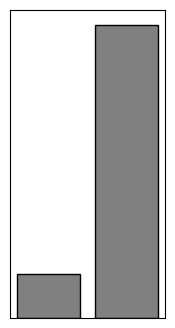

In [35]:
import matplotlib.pyplot as plt

a = 10000
ratio = 6.67
# Provided list
x = [0]*a + [1]*int(a*ratio)

plt.figure(figsize=(2, 4))
plt.hist(x, bins=[-0.5, 0.5, 1.5], edgecolor='black', color='grey', rwidth=0.8)
plt.xticks([])
plt.yticks([])
plt.show()